PyGSLIB
========

Trans
---------------

The GSLIb equivalent parameter file is

```
                  Parameters for TRANS
                  ********************

START OF PARAMETERS:
1                         \1=continuous, 0=categorical
data/true.dat          \file with reference distribution
1   0                     \   columns for variable and weight(0=none)
data/cluster.dat       \file with original distributions
3   0                     \   columns for variable and weight(0=none)
-1.0e21  1.0e21           \trimming limits
trans.out                 \file for transformed distributions
1                         \number of realizations or "sets" to trans
50  50  1                 \categorical: nx, ny, nz: size of 3-D model
 2   2  0                 \   wx, wy, wz: window size for tie-breaking
1000                      \continuous: number to transform per "set"
0.0   75.0                \   minimum and maximum values
1      1.0                \   lower tail: option, parameter
1     75.0                \   upper tail: option, parameter
1                         \honor local data? (1=yes, 0=no)
data/kt3d.out             \   file with estimation variance
2                         \   column number
0.5                       \   control parameter ( 0.33 < w < 3.0 )
69069                     \   random number seed (conditioning cat.)
```



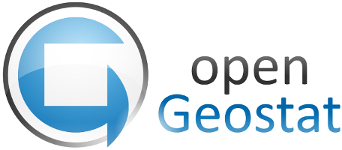

In [1]:
#general imports
import matplotlib.pyplot as plt   
import pygslib  
import numpy as np
import pandas as pd

#make the plots inline
%matplotlib inline  

Getting the data ready for work
---------
If the data is in GSLIB format you can use the function `gslib.read_gslib_file(filename)` to import the data into a Pandas DataFrame. 


In [2]:
#get the data in gslib format into a pandas Dataframe
true= pygslib.gslib.read_gslib_file('../datasets/true.dat')  
cluster  = pygslib.gslib.read_gslib_file('../datasets/cluster.dat')
kt3d   = pygslib.gslib.read_gslib_file('../datasets/kt3d.out')

print ('\t\ttrue \n', true.tail())
print ('\n\t\tcluster \n',cluster.tail())
print ('\n\t\tkt3d \n',kt3d.tail())  



		true 
       Primary  Secondary
2495     7.11       8.82
2496     9.26       7.97
2497     1.86       8.62
2498     1.12       6.59
2499     1.65       5.83

		cluster 
      Xlocation  Ylocation  Primary  Secondary  Declustering Weight
135       31.5       41.5    22.75       8.21                0.427
136       34.5       32.5     9.42       6.76                0.413
137       35.5       31.5     8.48      12.78                0.419
138       35.5       33.5     2.82       9.21                0.271
139       36.5       32.5     5.26      12.40                0.252

		kt3d 
       Estimate  EstimationVariance
2495  2.937663            0.917606
2496  2.872078            0.923014
2497  2.828578            0.927932
2498  2.809077            0.935380
2499  2.742379            0.947292


### Some Stats
Here we check we are not incorporating undefined values (see minimum and max) and that we have the same number of rows in the reference distribution (*true.dat*) and in the file with estimation variance (*kt3d.out*)

In [3]:
print ('\t\ttrue \n', true.describe())
print ('\n\t\tcluster \n',cluster.describe())
print ('\n\t\tkt3d \n',kt3d.describe())


		true 
            Primary    Secondary
count  2500.000000  2500.000000
mean      2.580196     2.320084
std       5.151933     2.705845
min       0.010000     0.110000
25%       0.340000     0.640000
50%       0.960000     1.350000
75%       2.560000     2.820000
max     102.700000    22.460000

		cluster 
         Xlocation   Ylocation     Primary   Secondary  Declustering Weight
count  140.000000  140.000000  140.000000  140.000000           140.000000
mean    23.321429   25.607143    4.350429    4.140214             1.000021
std     14.461692   13.594697    6.726625    4.508008             0.542023
min      0.500000    0.500000    0.060000    0.180000             0.252000
25%      9.500000   14.250000    0.700000    0.787500             0.445000
50%     25.500000   27.000000    2.195000    2.375000             1.012000
75%     35.500000   36.500000    5.327500    5.580000             1.416000
max     48.500000   48.500000   58.320000   22.460000             2.023000

		kt3d 
      

## Testing trans

In [4]:
print (pygslib.gslib.__trans.trans.__doc__)

gmedian,rvr,rcdf,ncut,zval,error = trans(ivtype,vr,wt,vo,wo,nx,ny,nz,wx,wy,wz,nxyza,zmin,zmax,ltpar,utpar,ltail,utail,ldata,kv,ef,rseed,[nr,no])

Wrapper for ``trans``.

Parameters
----------
ivtype : input int
vr : input rank-1 array('f') with bounds (nr)
wt : input rank-1 array('f') with bounds (nr)
vo : input rank-1 array('f') with bounds (no)
wo : input rank-1 array('f') with bounds (no)
nx : input int
ny : input int
nz : input int
wx : input int
wy : input int
wz : input int
nxyza : input int
zmin : input float
zmax : input float
ltpar : input float
utpar : input float
ltail : input int
utail : input int
ldata : input int
kv : input rank-1 array('f') with bounds (nr)
ef : input float
rseed : input int

Other Parameters
----------------
nr : input int, optional
    Default: len(vr)
no : input int, optional
    Default: len(vo)

Returns
-------
gmedian : float
rvr : rank-1 array('f') with bounds (nr)
rcdf : rank-1 array('f') with bounds (nr)
ncut : int
zval : rank-1 array('f') with 

In [5]:
true['Weight'] =1
cluster['NO-Weight']=1
parameters_trans = {
        'ivtype' : 1,                           # 1=continuous, 0=categorical (in this case vo may have nxyza raws?)
        'vr'     : true['Primary'],             # reference distribution (variable )
        'wt'     : true['Weight'],              # reference distribution (weight)
        'vo'     : cluster['Primary'],           # calibration scatterplot (secondary data)
        'wo'     : cluster['NO-Weight'],        # calibration scatterplot (weight data)
        'nx'     : 50 ,                          #categorical: nx, ny, nz: size of 3-D model
        'ny'     : 50,                           
        'nz'     : 1,
        'wx'     : 2,                            #   wx, wy, wz: window size for tie-breaking
        'wy'     : 2,
        'wz'     : 0,
        'nxyza'  : 2500,                         # continuous: number to transform per "set"
        'zmin'   : 0 ,                           # minimum and maximum values
        'zmax'   : 75,
        'ltpar'  : 1,                            # lower/upper tail: option, parameter
        'utpar'  : 75,
        'ltail'  : 1,
        'utail'  : 1,
        'ldata'  : 1,                           # honor local data?
        'kv'     : kt3d['EstimationVariance'].values,
        'ef'     : 0.5,                         # control parameter ( 0.33 < w < 3.0 )
        'rseed'  : 69069}                       #  random number seed (conditioning cat.)

gmedian,rvr,rcdf,ncut,zval,error = pygslib.gslib.__trans.trans(**parameters_trans)

print ('error ? ',  error != 0, error)


error ?  False 0


## Comparing results with gslib

In [6]:
print ('gmedian', gmedian)
print ('zval')
print (pd.DataFrame({'transformed variable':zval}).head(6))
print (pd.DataFrame({'transformed variable':zval}).tail(6))


gmedian 0.9599999785423279
zval
   transformed variable
0              0.044571
1              0.039969
2              0.062263
3              0.078095
4              0.072143
5              0.088190
     transformed variable
134             18.867838
135             23.231010
136              6.642549
137              4.914735
138              1.597002
139              2.867500


**Results in GSLIB ** 
```
     0.04457
     0.03996
     0.06228
     0.07809
     0.07216
     0.08818

***
      18.868
      23.231
       6.643
       4.917
       1.598
       2.869
```

In [7]:
# not in gslib output, not used here because this is continuous
i= np.arange(len(rcdf))+1

print (pd.DataFrame({'i':i, 'rcdf': rcdf, 'rvr': rvr}). head())
print (pd.DataFrame({'i':i, 'rcdf': rcdf, 'rvr': rvr}). tail())


   i    rcdf   rvr
0  1  0.0002  0.01
1  2  0.0006  0.01
2  3  0.0010  0.01
3  4  0.0014  0.02
4  5  0.0018  0.02
         i      rcdf         rvr
2495  2496  0.998215   43.500000
2496  2497  0.998615   46.529999
2497  2498  0.999015   54.389999
2498  2499  0.999415   58.320000
2499  2500  0.999815  102.699997


**expected results**

By adding this into GSLIB code 

```
	  print *, 'i', 'rcdf(i)', 'rvr(i)'
      do i=1,ncut
	      print *, i, rcdf(i), rvr(i)
      end do
```
we get this results 

```


           1   1.99999995E-04   9.99999978E-03
           2   5.99999970E-04   9.99999978E-03
           3   9.99999931E-04   9.99999978E-03
           4   1.39999995E-03   1.99999996E-02
           5   1.79999997E-03   1.99999996E-02
******
        2496  0.998214602       43.5000000    
        2497  0.998614550       46.5299988    
        2498  0.999014616       54.3899994    
        2499  0.999414563       58.3199997    
        2500  0.999814570       102.699997 
```

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

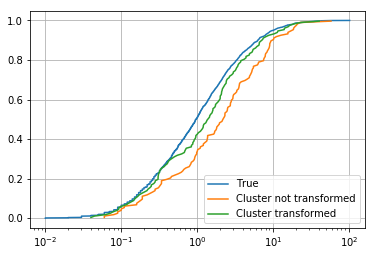

In [8]:

parameters_probplt = {
        'iwt'  : 0,                             #int, 1 use declustering weight
        'va'   : true['Primary'],             # array('d') with bounds (nd)
        'wt'   : true['Weight']} # array('d') with bounds (nd), wight variable (obtained with declust?)


binval,cl,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax,xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot (cl, binval, label = 'True')
parameters_probplt['va'] = cluster['Primary']
parameters_probplt['wt'] = cluster['NO-Weight']
binval,cl,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax,xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)
plt.plot (cl, binval,  label = 'Cluster not transformed')
parameters_probplt['va'] = zval
parameters_probplt['wt'] = cluster['NO-Weight']
binval,cl,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax,xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)
plt.plot (cl, binval,  label = 'Cluster transformed')
plt.grid(True)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.legend(loc=4)
fig.show
